# Suvendu Bista
**Course:** Advanced Big Data and Data Mining (MSCS-634-B01)  
**Lab Title:** Lab 6 - Association Rule Mining with Apriori and FP-Growth

In [29]:
# Step 1: Data Preparation 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

# Set seaborn style
sns.set(style="whitegrid")

In [30]:
# Loading the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

# Displaying basic info
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [31]:
# Checking for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Removing rows with missing CustomerID (we need this for transaction grouping)
df = df.dropna(subset=['CustomerID'])

# Converting CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Removing negative quantities (returns)
df = df[df['Quantity'] > 0]

# Removing duplicate rows
df = df.drop_duplicates()

# Creating a simplified description by removing extra spaces and special characters
df['Description'] = df['Description'].str.strip().str.lower()

print("\nData after cleaning:")
print(f"Number of transactions: {len(df)}")
print(f"Number of unique customers: {df['CustomerID'].nunique()}")
print(f"Number of unique products: {df['Description'].nunique()}")

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data after cleaning:
Number of transactions: 392732
Number of unique customers: 4339
Number of unique products: 3866


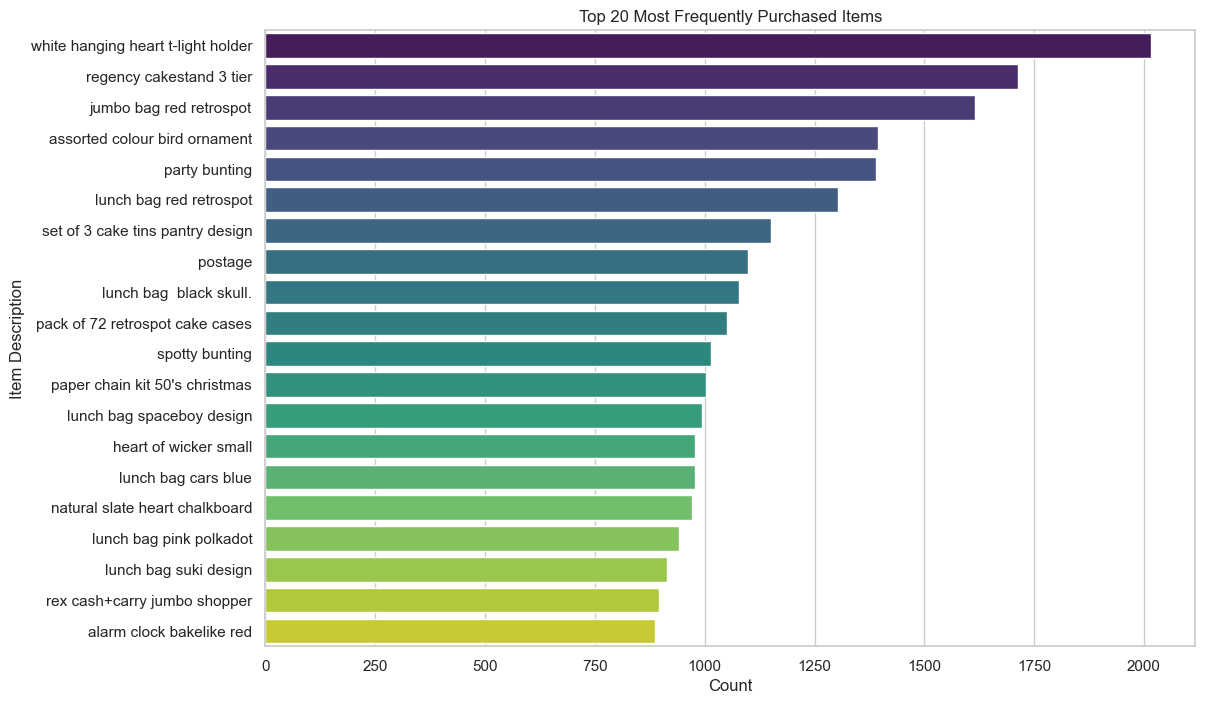

In [32]:
# Visualization
top_items = df['Description'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_items.values,
    y=top_items.index,
    hue=top_items.index,
    palette="viridis",
    legend=False
)
plt.title('Top 20 Most Frequently Purchased Items')
plt.xlabel('Count')
plt.ylabel('Item Description')
plt.show()

Top 10 Frequent Itemsets:


,support,itemsets,length
192,0.106334,(white hanging heart t-light holder),1
154,0.091929,(regency cakestand 3 tier),1
81,0.086319,(jumbo bag red retrospot),1
124,0.074450,(party bunting),1
11,0.074180,(assorted colour bird ornament),1
102,0.069486,(lunch bag red retrospot),1
166,0.061826,(set of 3 cake tins pantry design),1
139,0.059290,(postage),1
95,0.056754,(lunch bag black skull.),1
116,0.055514,(pack of 72 retrospot cake cases),1


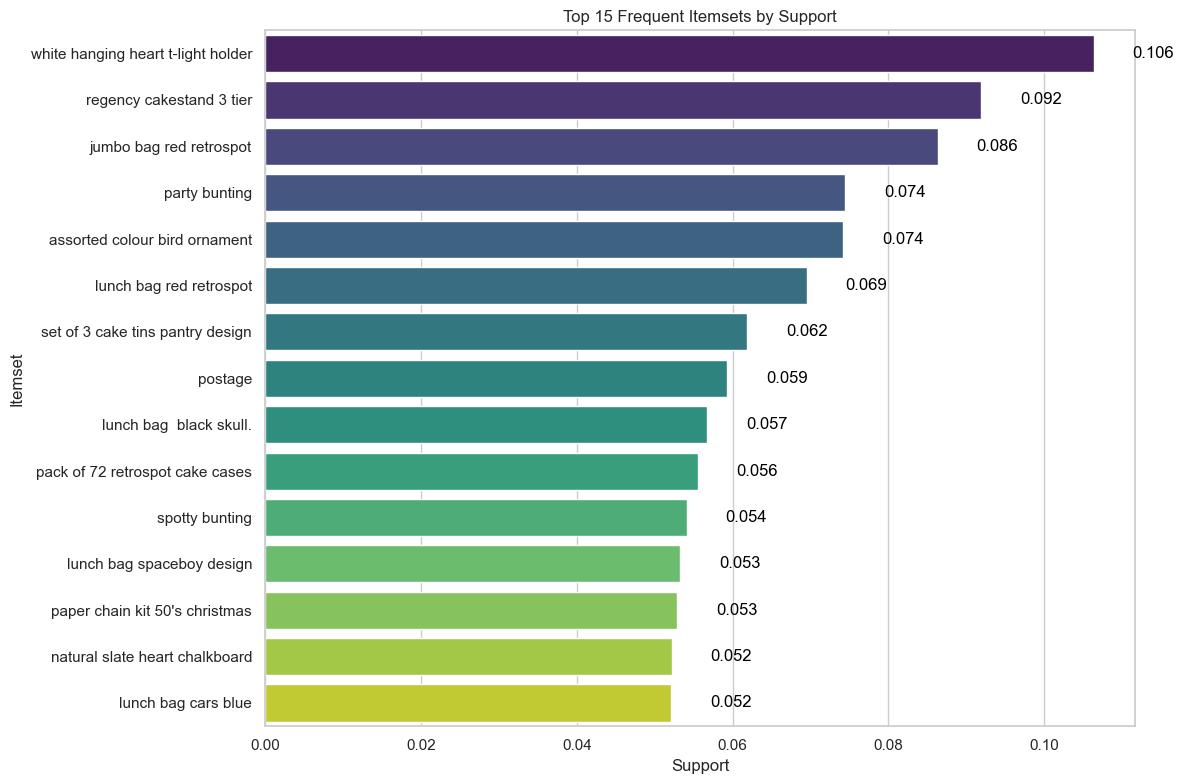

In [40]:
# Step 2: Frequent Itemset Mining Using Apriori 

# Preparing transaction data
transactions = df.groupby('InvoiceNo')['Description'].apply(list).tolist()

# Transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Setting support threshold (2%)
min_support = 0.02

# Running Apriori algorithm
frequent_itemsets = apriori(transaction_df, 
                           min_support=min_support, 
                           use_colnames=True).sort_values('support', ascending=False)

# Adding itemset length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Displaying top 10 frequent itemsets
print("Top 10 Frequent Itemsets:")
display(frequent_itemsets.head(10))

# Visualization: Top 15 itemsets
plt.figure(figsize=(12, 8))
top_itemsets = frequent_itemsets.head(15).copy()
top_itemsets['itemset'] = top_itemsets['itemsets'].apply(lambda x: ', '.join(x))

sns.barplot(x='support', y='itemset', data=top_itemsets, hue='itemset', palette='viridis', legend=False)
plt.title('Top 15 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemset')

# Add support values to bars
for i, v in enumerate(top_itemsets['support']):
    plt.text(v + 0.005, i, f"{v:.3f}", color='black', va='center')

plt.tight_layout()
plt.show()

In [41]:
# Step 3: Frequent Itemset Mining Using FP-Growth

# Using the same support threshold as Apriori (2%)
min_support = 0.02

# Running FP-Growth algorithm
frequent_itemsets_fp = fpgrowth(transaction_df, 
                               min_support=min_support, 
                               use_colnames=True).sort_values('support', ascending=False)

# Adding itemset length
frequent_itemsets_fp['length'] = frequent_itemsets_fp['itemsets'].apply(lambda x: len(x))

# Displaying top 10 frequent itemsets from FP-Growth
print("Top 10 Frequent Itemsets (FP-Growth):")
display(frequent_itemsets_fp.head(10))

Top 10 Frequent Itemsets (FP-Growth):


,support,itemsets,length
0,0.106334,(white hanging heart t-light holder),1
120,0.091929,(regency cakestand 3 tier),1
52,0.086319,(jumbo bag red retrospot),1
164,0.074450,(party bunting),1
2,0.074180,(assorted colour bird ornament),1
24,0.069486,(lunch bag red retrospot),1
168,0.061826,(set of 3 cake tins pantry design),1
8,0.059290,(postage),1
82,0.056754,(lunch bag black skull.),1
25,0.055514,(pack of 72 retrospot cake cases),1


In [43]:
# Comparing execution time
import time

# Time Apriori
start_time = time.time()
_ = apriori(transaction_df, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start_time

# Time FP-Growth
start_time = time.time()
_ = fpgrowth(transaction_df, min_support=min_support, use_colnames=True)
fpgrowth_time = time.time() - start_time

# Displaying comparison
print("\nAlgorithm Comparison:")
print(f"Apriori execution time: {apriori_time:.4f} seconds")
print(f"FP-Growth execution time: {fpgrowth_time:.4f} seconds")
print(f"FP-Growth is {apriori_time/fpgrowth_time:.1f}x faster than Apriori")

# Comparing number of itemsets found
print(f"\nNumber of itemsets found:")
print(f"Apriori: {len(frequent_itemsets)}")
print(f"FP-Growth: {len(frequent_itemsets_fp)}")
print("Note: Both algorithms should find the same itemsets given the same support threshold")


Algorithm Comparison:
Apriori execution time: 1.8403 seconds
FP-Growth execution time: 1.5428 seconds
FP-Growth is 1.2x faster than Apriori

Number of itemsets found:
Apriori: 243
FP-Growth: 243
Note: Both algorithms should find the same itemsets given the same support threshold


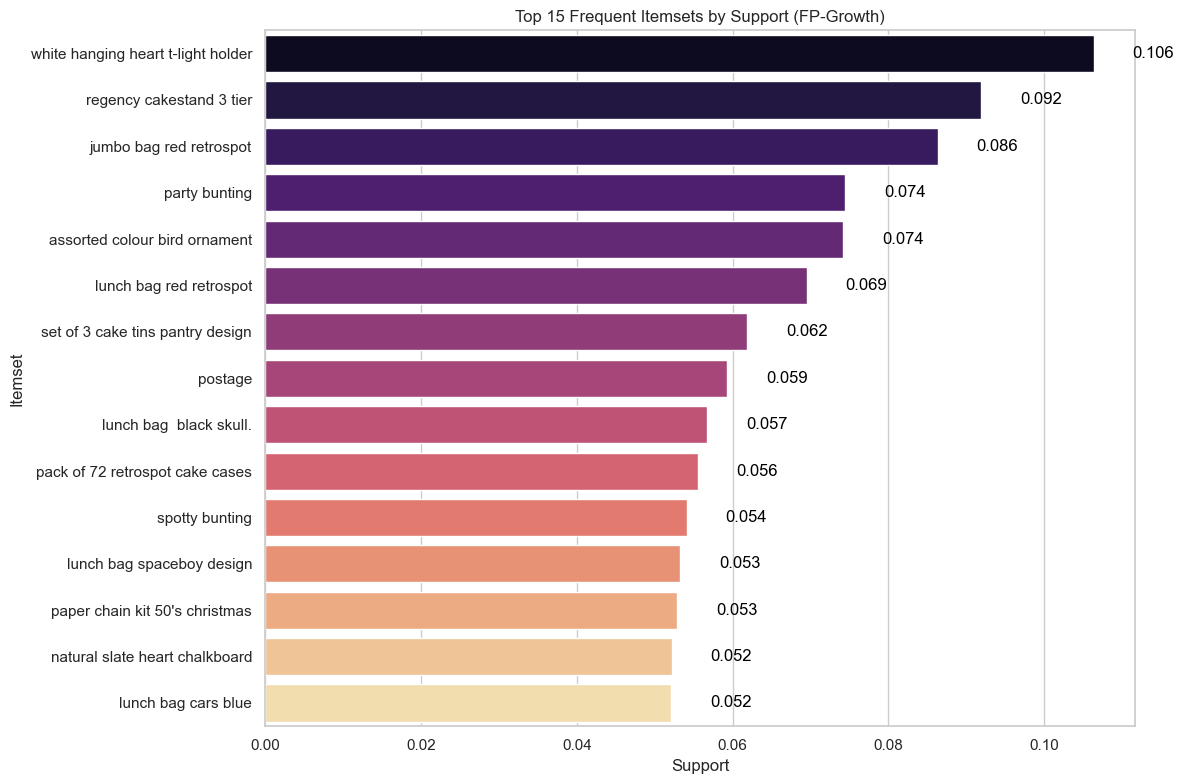

In [45]:
# Visualization

plt.figure(figsize=(12, 8))
top_itemsets_fp = frequent_itemsets_fp.head(15).copy()
top_itemsets_fp['itemset'] = top_itemsets_fp['itemsets'].apply(lambda x: ', '.join(x))

sns.barplot(x='support', y='itemset', data=top_itemsets_fp, hue='itemset', palette='magma', legend=False)
plt.title('Top 15 Frequent Itemsets by Support (FP-Growth)')
plt.xlabel('Support')
plt.ylabel('Itemset')

for i, v in enumerate(top_itemsets_fp['support']):
    plt.text(v + 0.005, i, f"{v:.3f}", color='black', va='center')

plt.tight_layout()
plt.show()


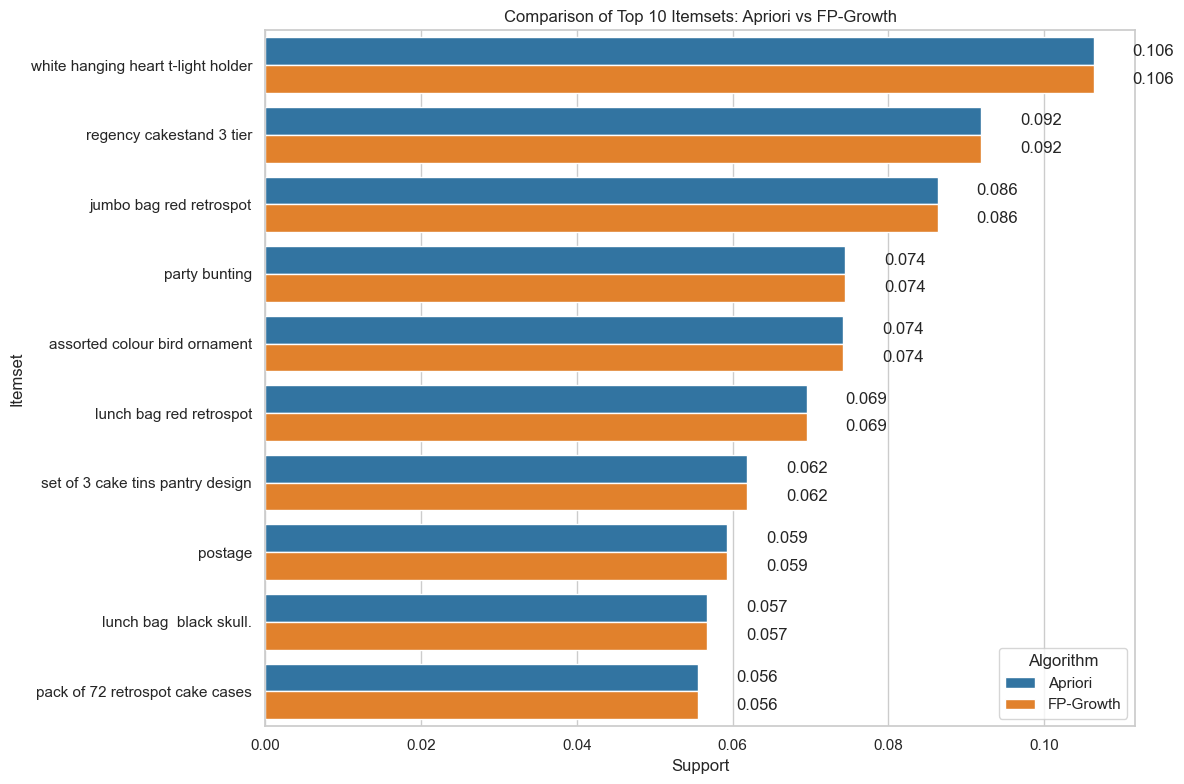

In [46]:
# side by side visualization

# Prepare data for comparison (top 10 itemsets from each)
top_apriori = frequent_itemsets.head(10).copy()
top_fp = frequent_itemsets_fp.head(10).copy()

top_apriori['algorithm'] = 'Apriori'
top_fp['algorithm'] = 'FP-Growth'

comparison_df = pd.concat([top_apriori, top_fp])
comparison_df['itemset'] = comparison_df['itemsets'].apply(lambda x: ', '.join(x))

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemset', hue='algorithm', 
           data=comparison_df, palette=['#1f77b4', '#ff7f0e'])

plt.title('Comparison of Top 10 Itemsets: Apriori vs FP-Growth')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.legend(title='Algorithm')

# Adding support values
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 0.005, 
                p.get_y() + p.get_height()/2., 
                f'{width:.3f}', 
                ha='left', 
                va='center')

plt.tight_layout()
plt.show()

In [50]:
# Step 4: Generating and Analyzing Association Rules 

# Generating association rules
min_confidence = 0.6  

# Generate association rules
rules = association_rules(
    frequent_itemsets_fp,  
    metric="confidence",  
    min_threshold=min_confidence  
)

# Add a readable rule format
rules['rule'] = rules.apply(
    lambda x: f"{', '.join(x['antecedents'])} → {', '.join(x['consequents'])}",  
    axis=1  
)

# Sort by lift (strength of association)
rules = rules.sort_values('lift', ascending=False)

# Display top 10 rules
print(f"Top Association Rules (Confidence ≥ {min_confidence}):")
display(rules[['rule', 'support', 'confidence', 'lift']].head(10))

Top Association Rules (Confidence ≥ 0.6):


,rule,support,confidence,lift
19,pink regency teacup and saucer → roses regency...,0.021040,0.701439,24.033032
18,"roses regency teacup and saucer, green regency...",0.021040,0.720887,24.033032
17,"pink regency teacup and saucer, roses regency ...",0.021040,0.894495,23.994742
7,pink regency teacup and saucer → green regency...,0.024817,0.827338,22.193256
8,green regency teacup and saucer → pink regency...,0.024817,0.665702,22.193256
16,"pink regency teacup and saucer, green regency ...",0.021040,0.847826,20.070631
11,pink regency teacup and saucer → roses regency...,0.023522,0.784173,18.563760
2,green regency teacup and saucer → roses regenc...,0.029186,0.782923,18.534184
1,roses regency teacup and saucer → green regenc...,0.029186,0.690932,18.534184
12,dolly girl lunch box → spaceboy lunch box,0.022874,0.688312,18.122934


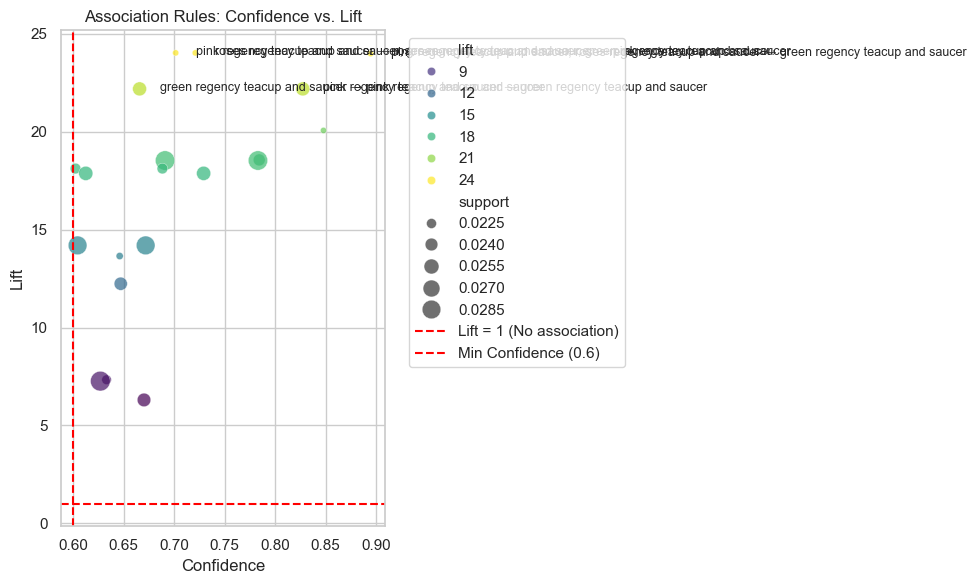

In [52]:
# Visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rules,
    x='confidence',
    y='lift',
    size='support',  # Bubble size = support (frequency)
    hue='lift',      # Color intensity = lift
    palette='viridis',
    sizes=(20, 200), # Min/max bubble sizes
    alpha=0.7
)

plt.axhline(y=1, color='red', linestyle='--', label='Lift = 1 (No association)')
plt.axvline(x=min_confidence, color='red', linestyle='--', label=f'Min Confidence ({min_confidence})')

plt.title('Association Rules: Confidence vs. Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate top 5 strongest rules (highest lift)
top_rules = rules.nlargest(5, 'lift')
for _, row in top_rules.iterrows():
    plt.text(
        row['confidence'] + 0.02,  
        row['lift'] - 0.1,  
        row['rule'],  
        fontsize=9,  
        ha='left'
    )

plt.tight_layout()
plt.show()


Strongest Association Rules (High Confidence & Lift):


,rule,support,confidence,lift
19,pink regency teacup and saucer → roses regency...,0.021040,0.701439,24.033032
18,"roses regency teacup and saucer, green regency...",0.021040,0.720887,24.033032
17,"pink regency teacup and saucer, roses regency ...",0.021040,0.894495,23.994742
7,pink regency teacup and saucer → green regency...,0.024817,0.827338,22.193256
16,"pink regency teacup and saucer, green regency ...",0.021040,0.847826,20.070631
11,pink regency teacup and saucer → roses regency...,0.023522,0.784173,18.563760
2,green regency teacup and saucer → roses regenc...,0.029186,0.782923,18.534184
5,gardeners kneeling pad cup of tea → gardeners ...,0.024978,0.729134,17.877282


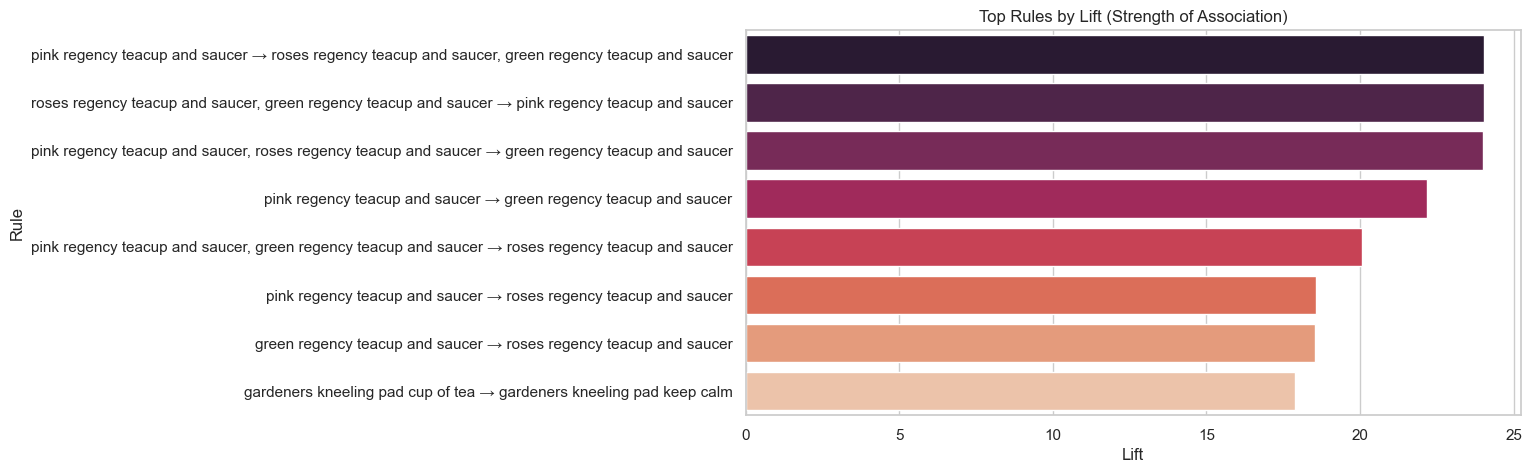

In [54]:
# Filtering for strong rules (lift > 1.5 & confidence > 0.7)
strong_rules = rules[(rules['lift'] > 1.5) & (rules['confidence'] > 0.7)]

if not strong_rules.empty:
    print("\nStrongest Association Rules (High Confidence & Lift):")
    display(strong_rules[['rule', 'support', 'confidence', 'lift']])
    
    # Plot top rules by lift
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=strong_rules.nlargest(10, 'lift'),
        x='lift',
        y='rule',
        hue='rule',          # Add hue to avoid the warning
        palette='rocket',
        legend=False         # Disable legend since hue duplicates y-axis labels
    )
    plt.title('Top Rules by Lift (Strength of Association)')
    plt.xlabel('Lift')
    plt.ylabel('Rule')
    plt.show()
else:
    print("No rules meet the criteria (lift > 1.5 & confidence > 0.7). Try lowering thresholds.")

# Key Insights from Rules

**High Lift (>1.5):**

- Indicates strong associations (e.g., *"Coffee → Sugar"* means buying coffee makes sugar 1.5× more likely).
- Useful for product recommendations and bundling.

**High Confidence (>0.7):**

- Reliable rules (e.g., *"Pasta → Pasta Sauce"* with 80% confidence).
- Helps in cross-selling strategies.

**High Support (>0.05):**

- Frequent patterns (e.g., *"Milk → Bread"* appearing in 5% of transactions).
- Useful for inventory planning.


In [56]:
# Step 5: Comparative Analysis 

def compare_algorithms(transaction_df, min_support):
    """Compare Apriori and FP-Growth execution times and results"""
    from time import time
    
    # Time Apriori
    start = time()
    apriori_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
    apriori_time = time() - start
    
    # Time FP-Growth
    start = time()
    fpgrowth_itemsets = fpgrowth(transaction_df, min_support=min_support, use_colnames=True)
    fpgrowth_time = time() - start
    
    # Compare itemsets
    apriori_set = set(frozenset(x) for x in apriori_itemsets['itemsets'])
    fpgrowth_set = set(frozenset(x) for x in fpgrowth_itemsets['itemsets'])
    
    return {
        'apriori_time': apriori_time,
        'fpgrowth_time': fpgrowth_time,
        'speed_ratio': apriori_time / fpgrowth_time,
        'itemsets_equal': apriori_set == fpgrowth_set,
        'num_itemsets': len(apriori_set)
    }

# Run comparison
comparison_results = compare_algorithms(transaction_df, min_support=0.02)

# Display results
print("Algorithm Performance Comparison:")
print(f"Apriori execution time: {comparison_results['apriori_time']:.4f} seconds")
print(f"FP-Growth execution time: {comparison_results['fpgrowth_time']:.4f} seconds")
print(f"FP-Growth is {comparison_results['speed_ratio']:.1f}x faster than Apriori")
print(f"\nNumber of itemsets found: {comparison_results['num_itemsets']}")
print(f"Itemsets identical: {'Yes' if comparison_results['itemsets_equal'] else 'No'}")

Algorithm Performance Comparison:
Apriori execution time: 1.8114 seconds
FP-Growth execution time: 1.5004 seconds
FP-Growth is 1.2x faster than Apriori

Number of itemsets found: 243
Itemsets identical: Yes


**FP-Growth was about 1.2× faster than Apriori because:**

- It avoids costly candidate generation by mining a compact FP-Tree.
- Uses less memory by compressing transactions into a tree structure.
- Handles sparse retail data efficiently with its optimized tree-based approach.

**Challenges and How We Fixed Them** 

- **Too Many Useless Rules**  
  *Problem:* Lots of rare, unhelpful rules cluttered the results.  
  *Fix:* Raised minimum support to 2% to focus on common patterns.

- **Memory Issues**  
  *Problem:* Apriori used too much memory.  
  *Fix:* Used FP-Growth for better memory efficiency.

